# LangChain + Function Calling + E2B Code Interpreter        
**Powered by open-source [Code Interpreter SDK](https://github.com/e2b-dev/code-interpreter) by [E2B](https://e2b.dev/docs)**

E2B's code interpreter SDK quickly creates a secure cloud sandbox powered by [Firecracker](https://github.com/firecracker-microvm/firecracker).

Inside this sandbox is a running Jupyter server that the LLM can use.

### Step 1: Install dependencies

We start by install the [E2B code interpreter SDK](https://github.com/e2b-dev/code-interpreter) and [LangChain Python SDK](https://console.groq.com/).

In [1]:
%pip install e2b-code-interpreter langchain langchainhub langchain-openai

Note: you may need to restart the kernel to use updated packages.


### Step 2: Define API keys, prompt, and tools

Let's define our variables with API keys for OpenAI and E2B.

In [2]:
import os

# TODO: Get your OpenAI API key from https://platform.openai.com/api-keys
os.environ["OPENAI_API_KEY"] = ""

# TODO: Get your E2B API key from https://e2b.dev/docs
os.environ["E2B_API_KEY"] = ""

### Step 3: Implement the method for code interpreting

Here's the tool definition that uses the E2B code interpreter SDK. We'll be using this to get the E2B code interpreter tool and to format the output of the tool.

In [3]:
import os
import json

from typing import Any, List
from langchain_core.tools import Tool
from pydantic.v1 import BaseModel, Field
from e2b_code_interpreter import CodeInterpreter
from langchain_core.messages import BaseMessage, ToolMessage
from langchain.agents.output_parsers.tools import (
    ToolAgentAction,
)


class LangchainCodeInterpreterToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")


class CodeInterpreterFunctionTool:
    """
    This class calls arbitrary code against a Python Jupyter notebook.
    It requires an E2B_API_KEY to create a sandbox.
    """

    tool_name: str = "code_interpreter"

    def __init__(self):
        # Instantiate the E2B sandbox - this is a long lived object
        # that's pinging E2B cloud to keep the sandbox alive.
        if "E2B_API_KEY" not in os.environ:
            raise Exception(
                "Code Interpreter tool called while E2B_API_KEY environment variable is not set. Please get your E2B api key here https://e2b.dev/docs and set the E2B_API_KEY environment variable."
            )
        self.code_interpreter = CodeInterpreter()

    def call(self, parameters: dict, **kwargs: Any):
        code = parameters.get("code", "")
        print(f"***Code Interpreting...\n{code}\n====")
        execution = self.code_interpreter.notebook.exec_cell(code)
        return {
            "results": execution.results,
            "stdout": execution.logs.stdout,
            "stderr": execution.logs.stderr,
            "error": execution.error,
        }

    def close(self):
        self.code_interpreter.close()

    # langchain does not return a dict as a parameter, only a code string
    def langchain_call(self, code: str):
        return self.call({"code": code})

    def to_langchain_tool(self) -> Tool:
        tool = Tool(
            name=self.tool_name,
            description="Execute python code in a Jupyter notebook cell and returns any rich data (eg charts), stdout, stderr, and error.",
            func=self.langchain_call,
        )
        tool.args_schema = LangchainCodeInterpreterToolInput
        return tool

    @staticmethod
    def format_to_tool_message(
        agent_action: ToolAgentAction,
        observation: dict,
    ) -> List[BaseMessage]:
        """
        Format the output of the CodeInterpreter tool to be returned as a ToolMessage.
        """
        new_messages = list(agent_action.message_log)

        # TODO: Add info about the results for the LLM
        content = json.dumps(
            {k: v for k, v in observation.items() if k not in ("results")}, indent=2
        )
        new_messages.append(
            ToolMessage(content=content, tool_call_id=agent_action.tool_call_id)
        )

        return new_messages

### Step 4: Implement the methods for formatting messages, create and invoke the LangChain agent



> Entering new AgentExecutor chain...

Invoking: `code_interpreter` with `{'code': "import matplotlib.pyplot as plt\nimport numpy as np\n\nx = np.linspace(0, 2*np.pi, 100)\ny = np.sin(x)\n\nplt.plot(x, y)\nplt.title('Sine Wave')\nplt.xlabel('x')\nplt.ylabel('sin(x)')\nplt.grid(True)\nplt.show()"}`


***Code Interpreting...
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

plt.plot(x, y)
plt.title('Sine Wave')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.grid(True)
plt.show()
====
{'results': [<e2b_code_interpreter.models.Result object at 0x11a267d90>], 'stdout': [], 'stderr': [], 'error': None}Here is a plot of the sine wave.

> Finished chain.


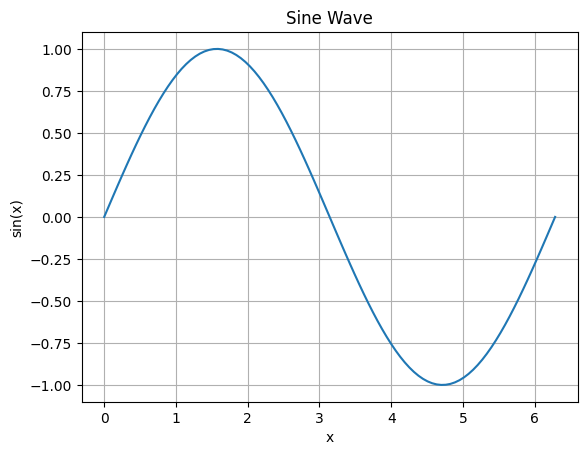

In [4]:
from typing import List, Sequence, Tuple
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnablePassthrough
from langchain.agents.output_parsers.tools import (
    ToolAgentAction,
    ToolsAgentOutputParser,
)

def format_to_tool_messages(
    intermediate_steps: Sequence[Tuple[ToolAgentAction, dict]],
) -> List[BaseMessage]:
    messages = []
    for agent_action, observation in intermediate_steps:
        if agent_action.tool == CodeInterpreterFunctionTool.tool_name:
            new_messages = CodeInterpreterFunctionTool.format_to_tool_message(
                agent_action,
                observation,
            )
            messages.extend([new for new in new_messages if new not in messages])
        else:
            # Handle other tools
            print("Not handling tool: ", agent_action.tool)

    return messages


# 1. Pick your favorite llm
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# 2. Initialize the code interpreter tool
code_interpreter = CodeInterpreterFunctionTool()
code_interpreter_tool = code_interpreter.to_langchain_tool()
tools = [code_interpreter_tool]


# 3. Define the prompt
prompt = ChatPromptTemplate.from_messages(
    [("human", "{input}"), ("placeholder", "{agent_scratchpad}")]
)

# 4. Define the agent
agent = (
    RunnablePassthrough.assign(
        agent_scratchpad=lambda x: format_to_tool_messages(x["intermediate_steps"])
    )
    | prompt
    | llm.bind_tools(tools)
    | ToolsAgentOutputParser()
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    return_intermediate_steps=True,
)

# 5. Invoke the agent
result = agent_executor.invoke({"input": "plot and show sinus"})

code_interpreter.close()

# Each intermediate step is a Tuple[ToolAgentAction, dict]
result["intermediate_steps"][0][1]["results"][0]